In [1]:
import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool


from dotenv import load_dotenv
import os

[23:36:37 -0600] [INFO]: NetworkX-cuGraph is unavailable: No module named 'nx_cugraph'.


In [2]:
load_dotenv()

True

In [3]:
# Access variables
openai_key = os.getenv('OPENAI_API_KEY')
arango_host = os.getenv('ARANGO_HOST')
arango_user = os.getenv('ARANGO_USER')
arango_password = os.getenv('ARANGO_PASSWORD')
arango_db = os.getenv('ARANGO_DB')


In [2]:

# Load nodes file
nodes_df = pd.read_csv('Data/marvel-bimodal-nodes.csv',
                       names=['ID', 'Label', 'type'],
                       header=0)

# Load edges file
edges_df = pd.read_csv('Data/marvel-bimodal-edges.csv',
                       names=['Source', 'Target'],
                       header=0)

# Display basic information
print("\nNodes DataFrame Info:")
print(nodes_df.info())
print("\nFirst few rows of nodes:")
print(nodes_df.head())

print("\nEdges DataFrame Info:")
print(edges_df.info())
print("\nFirst few rows of edges:")
print(edges_df.head())

# Basic network statistics
print("\nNetwork Statistics:")
print(f"Number of nodes: {len(nodes_df)}")
print(f"Number of edges: {len(edges_df)}")
print("\nNode types:")
print(nodes_df['type'].value_counts())

# Check for unique sources and targets
print("\nNumber of unique sources:", edges_df['Source'].nunique())
print("Number of unique targets:", edges_df['Target'].nunique())


Nodes DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19090 entries, 0 to 19089
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      19090 non-null  object
 1   Label   19090 non-null  object
 2   type    19090 non-null  object
dtypes: object(3)
memory usage: 447.5+ KB
None

First few rows of nodes:
                       ID                   Label   type
0                 2001 10                 2001 10  comic
1                  2001 8                  2001 8  comic
2                  2001 9                  2001 9  comic
3  24-HOUR MAN / EMMANUEL  24-HOUR MAN / EMMANUEL   hero
4  3-D MAN / CHARLES CHAN  3-D MAN / CHARLES CHAN   hero

Edges DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96104 entries, 0 to 96103
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Source  96104 non-null  object
 1   Target  96104 non-null  object

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Add nodes with their type and label
for _, row in nodes_df.iterrows():
    G.add_node(row['ID'], 
               type=row['type'],
               label=row['Label'])  # Adding the label attribute

# Add edges
for _, row in edges_df.iterrows():
    G.add_edge(row['Source'], row['Target'])



In [11]:
# Verify node attributes are properly set
print(G)
print("Sample node attributes:")
print(list(G.nodes(data=True))[:5])

Graph with 19091 nodes and 96104 edges
Sample node attributes:
[('2001 10', {'type': 'comic', 'label': '2001 10'}), ('2001 8', {'type': 'comic', 'label': '2001 8'}), ('2001 9', {'type': 'comic', 'label': '2001 9'}), ('24-HOUR MAN / EMMANUEL', {'type': 'hero', 'label': '24-HOUR MAN / EMMANUEL'}), ('3-D MAN / CHARLES CHAN', {'type': 'hero', 'label': '3-D MAN / CHARLES CHAN'})]


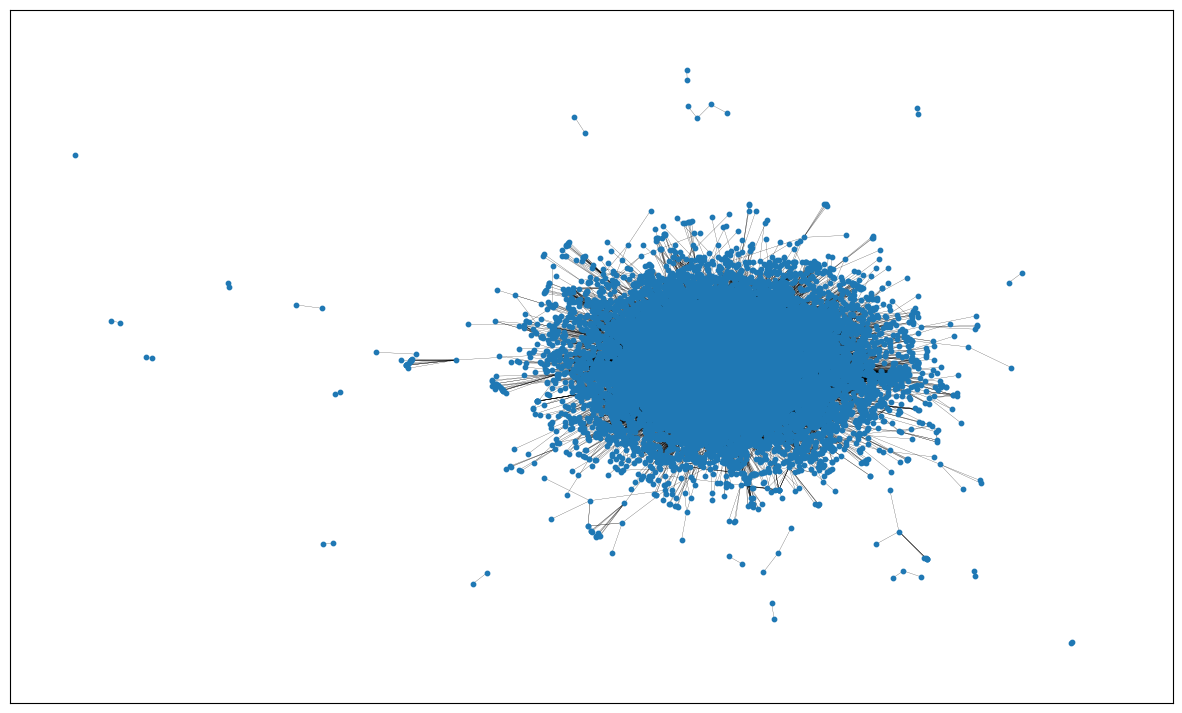

In [10]:
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

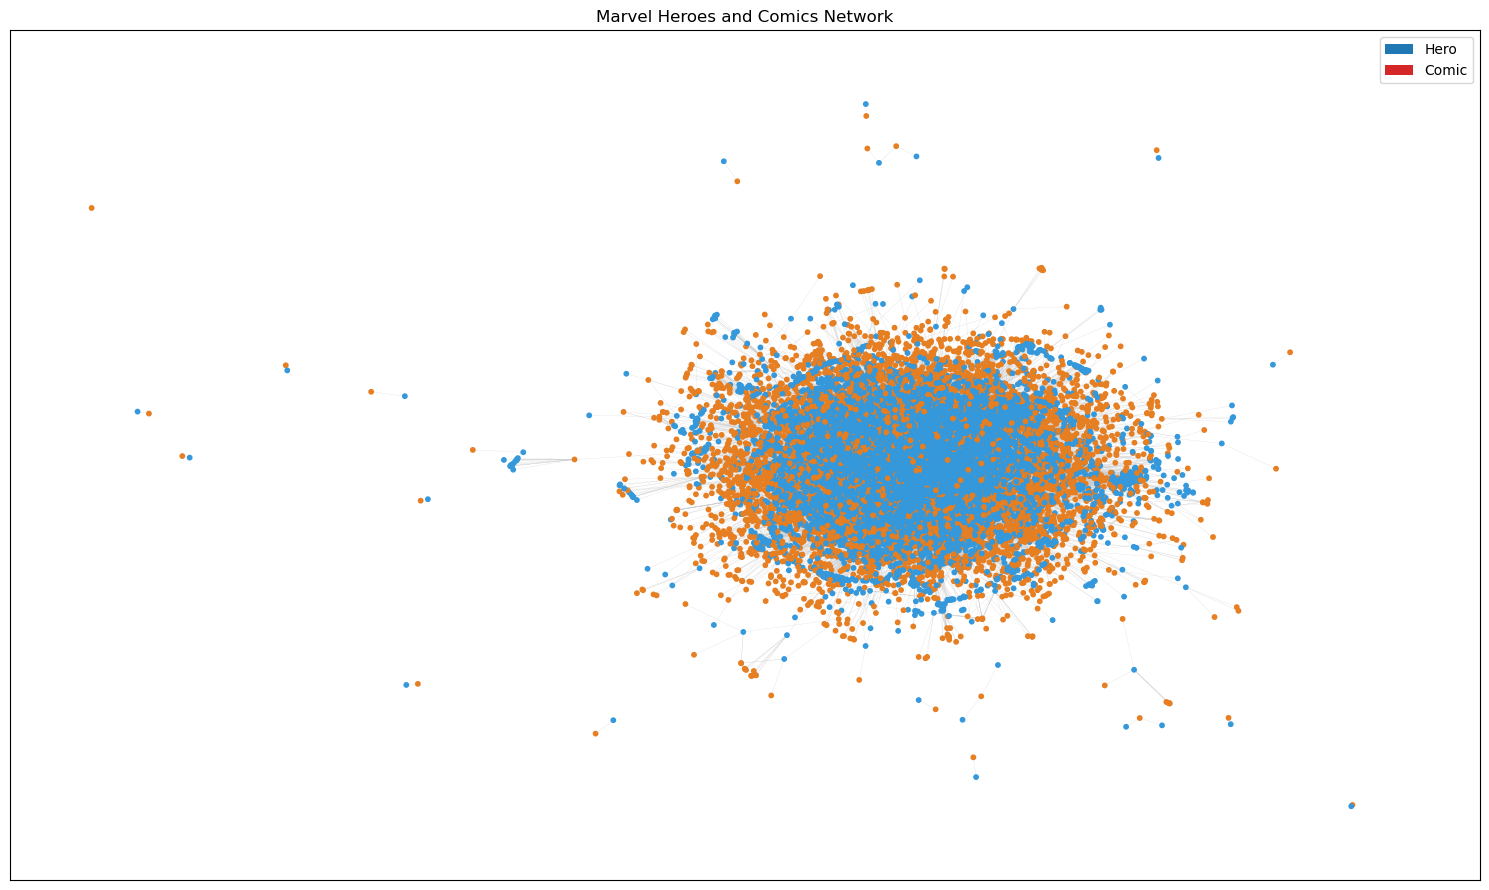

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt


# # Option 1: Blue and Red
# node_colors = ['#1f77b4' if G.nodes[node].get('type') == 'hero' else '#d62728' for node in G.nodes()]


# Option 3: Orange and Blue
node_colors = ['#e67e22' if G.nodes[node].get('type')== 'hero' else '#3498db' for node in G.nodes()]

# Set up plot options and draw
plot_options = {
    "node_size": 10, 
    "with_labels": False, 
    "width": 0.15,
    "node_color": node_colors,
    "edge_color": "#CCCCCC"  # Light gray edges
}

pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

# Add legend (update the colors to match your choice)
hero_patch = plt.Circle((0, 0), 0.02, fc='#1f77b4', label='Hero')
comic_patch = plt.Circle((0, 0), 0.02, fc='#d62728', label='Comic')
plt.legend(handles=[hero_patch, comic_patch])

plt.title("Marvel Heroes and Comics Network")
plt.tight_layout()
plt.show()

In [4]:
# Initialize the client for ArangoDB.
client = ArangoClient(hosts=arango_host)

# Connect to "test" database as root user.
sys_db = client.db("_system", username=arango_user, password=arango_password)

In [5]:
print(sys_db.collections())

[{'id': '11', 'name': '_jobs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '14', 'name': '_frontend', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '12', 'name': '_apps', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '9', 'name': '_aqlfunctions', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '6', 'name': '_statisticsRaw', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '13', 'name': '_appbundles', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '7', 'name': '_graphs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '4', 'name': '_statistics', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '10', 'name': '_queues', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '8', 'name': '_analyzers', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '5', 'name': '_statistics15', 'system': True, 'type': 'document', 'status': 'loaded'}

In [32]:

# Define the new database name
NEW_DATABASE_NAME = "Marvel"

# Create the database if it does not exist
if not sys_db.has_database(NEW_DATABASE_NAME):
    sys_db.create_database(NEW_DATABASE_NAME)
    print(f"Database '{NEW_DATABASE_NAME}' created successfully!")
else:
    print(f"Database '{NEW_DATABASE_NAME}' already exists.")

Database 'Marvel' created successfully!


In [6]:
db = client.db(arango_db, username=arango_user, password=arango_password)
print(db.collections())

[{'id': '8283', 'name': 'Heroes_Comics_node', 'system': False, 'type': 'document', 'status': 'loaded'}, {'id': '7458', 'name': '_aqlfunctions', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '7461', 'name': '_apps', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '8284', 'name': 'Heroes_Comics_node_to_Heroes_Comics_node', 'system': False, 'type': 'edge', 'status': 'loaded'}, {'id': '7459', 'name': '_queues', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '7462', 'name': '_appbundles', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '7456', 'name': '_graphs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '7457', 'name': '_analyzers', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '7460', 'name': '_jobs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '7463', 'name': '_frontend', 'system': True, 'type': 'document', 'status': 'loaded'}]


In [38]:
# Delete the existing Marvel graph
if db.has_graph('Marvel'):
    db.delete_graph('Marvel', drop_collections=True)
    print("Existing Marvel graph deleted")

Existing Marvel graph deleted


In [10]:
G_adb = nxadb.Graph(
    name="Heroes_Comics",
    db=db,
    edge_definitions=[{
        'edge_collection': 'marvel_edges',
        'from_vertex_collections': ['marvel_nodes'],
        'to_vertex_collections': ['marvel_nodes']
    }],
    incoming_graph_data=G,
    write_batch_size=50000
)
print(G_adb)

NameError: name 'G' is not defined

In [7]:

G_adb = nxadb.Graph(name="Heroes_Comics", db=db)

print(G_adb)

[23:37:01 -0600] [INFO]: Graph 'Heroes_Comics' exists.
[23:37:01 -0600] [INFO]: Default node type set to 'Heroes_Comics_node'


Graph named 'Heroes_Comics' with 19091 nodes and 96104 edges


In [13]:
print(G_adb.degree(100))

15


### AQL Test

In [48]:
# First, let's check what collections exist
print("Available collections:")
for collection in db.collections():
    print(collection['name'])

# Get the graph to see its collections
graph = db.graph('Heroes_Comics')
print("\nGraph collections:")
print(graph.edge_definitions())

Available collections:
Heroes_Comics_node
_aqlfunctions
_apps
Heroes_Comics_node_to_Heroes_Comics_node
_queues
_appbundles
_graphs
_analyzers
_jobs
_frontend

Graph collections:
[{'edge_collection': 'Heroes_Comics_node_to_Heroes_Comics_node', 'from_vertex_collections': ['Heroes_Comics_node'], 'to_vertex_collections': ['Heroes_Comics_node']}]


In [52]:
# 1. Find all heroes and their comic count
aql_heroes = """
FOR node IN Heroes_Comics_node
    FILTER node.type == 'hero'
    LET comic_count = LENGTH(
        FOR v, e IN 1..1 ANY node Heroes_Comics_node_to_Heroes_Comics_node
        FILTER v.type == 'comic'
        RETURN v
    )
    SORT comic_count DESC
    LIMIT 10
    RETURN {
        hero: node.label,
        comics: comic_count
    }
"""
print("Top 10 Heroes by Comic Appearances:")
cursor = db.aql.execute(aql_heroes)
for hero in cursor:
    print(f"{hero['hero']}: {hero['comics']} comics")


# 2. Find comics with most hero connections
aql_comics = """
FOR node IN Heroes_Comics_node
    FILTER node.type == 'comic'
    LET hero_count = LENGTH(
        FOR v, e IN 1..1 ANY node Heroes_Comics_node_to_Heroes_Comics_node
        FILTER v.type == 'hero'
        RETURN v
    )
    SORT hero_count DESC
    LIMIT 5
    RETURN {
        comic: node.label,
        heroes: hero_count
    }
"""
print("\nTop 5 Comics by Number of Heroes:")
cursor = db.aql.execute(aql_comics)
for comic in cursor:
    print(f"{comic['comic']}: {comic['heroes']} heroes")



# 3. Basic statistics
aql_stats = """
RETURN {
    total_nodes: LENGTH(Heroes_Comics_node),
    heroes: LENGTH(FOR n IN Heroes_Comics_node FILTER n.type == 'hero' RETURN n),
    comics: LENGTH(FOR n IN Heroes_Comics_node FILTER n.type == 'comic' RETURN n),
    edges: LENGTH(Heroes_Comics_node_to_Heroes_Comics_node)
}
"""
print("\nGraph Statistics:")
cursor = db.aql.execute(aql_stats)
for stats in cursor:
    print(f"Total Nodes: {stats['total_nodes']}")
    print(f"Heroes: {stats['heroes']}")
    print(f"Comics: {stats['comics']}")
    print(f"Total Connections: {stats['edges']}")




Top 10 Heroes by Comic Appearances:
CAPTAIN AMERICA: 1334 comics
IRON MAN / TONY STARK: 1150 comics
THING / BENJAMIN J. GR: 963 comics
THOR / DR. DONALD BLAK: 956 comics
HUMAN TORCH / JOHNNY S: 886 comics
MR. FANTASTIC / REED R: 854 comics
HULK / DR. ROBERT BRUC: 835 comics
WOLVERINE / LOGAN: 819 comics
INVISIBLE WOMAN / SUE: 762 comics
SCARLET WITCH / WANDA: 643 comics

Top 5 Comics by Number of Heroes:
COC 1: 110 heroes
IW 3: 90 heroes
IW 1: 89 heroes
H2 279: 86 heroes
IW 4: 80 heroes

Graph Statistics:
Total Nodes: 19091
Heroes: 6439
Comics: 12651
Total Connections: 96104


### Agent

In [8]:
arango_graph = ArangoGraph(db)

In [9]:
llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

llm.invoke("hello!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_523b9b6e5f', 'finish_reason': 'stop', 'logprobs': None}, id='run-4b72458e-94b6-4c93-b43b-101d05cd412d-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [10]:

@tool
def text_to_aql_to_text(query: str):
    """This tool is available to invoke the
    ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute
    the query, and translate the result back into Natural Language.
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    chain = ArangoGraphQAChain.from_llm(
    	llm=llm,
    	graph=arango_graph,
    	verbose=True,
        allow_dangerous_requests=True
    )
    
    result = chain.invoke(query)

    return str(result["result"])

In [11]:
print(arango_graph.schema)

{'Graph Schema': [{'graph_name': 'Heroes_Comics', 'edge_definitions': [{'edge_collection': 'Heroes_Comics_node_to_Heroes_Comics_node', 'from_vertex_collections': ['Heroes_Comics_node'], 'to_vertex_collections': ['Heroes_Comics_node']}]}], 'Collection Schema': [{'collection_name': 'Heroes_Comics_node', 'collection_type': 'document', 'document_properties': [{'name': '_key', 'type': 'str'}, {'name': '_id', 'type': 'str'}, {'name': '_rev', 'type': 'str'}, {'name': 'type', 'type': 'str'}, {'name': 'label', 'type': 'str'}], 'example_document': {'_key': '0', '_id': 'Heroes_Comics_node/0', '_rev': '_jOckVf6---', 'type': 'comic', 'label': '2001 10'}}, {'collection_name': 'Heroes_Comics_node_to_Heroes_Comics_node', 'collection_type': 'edge', 'edge_properties': [{'name': '_key', 'type': 'str'}, {'name': '_id', 'type': 'str'}, {'name': '_from', 'type': 'str'}, {'name': '_to', 'type': 'str'}, {'name': '_rev', 'type': 'str'}], 'example_edge': {'_key': '0', '_id': 'Heroes_Comics_node_to_Heroes_Comics

In [12]:
# 5. Define the Text to NetworkX/cuGraph Tool
# Note: It is encouraged to experiment and improve this section! This is just a placeholder:

@tool
def text_to_nx_algorithm_to_text(query):
    """This tool is available to invoke a NetworkX Algorithm on
    the ArangoDB Graph. You are responsible for accepting the
    Natural Language Query, establishing which algorithm needs to
    be executed, executing the algorithm, and translating the results back
    to Natural Language, with respect to the original query.

    If the query (e.g traversals, shortest path, etc.) can be solved using the Arango Query Language, then do not use
    this tool.
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    ######################
    print("1) Generating NetworkX code")

    text_to_nx = llm.invoke(f"""
    I have a NetworkX Graph called `G_adb`. It has the following schema: {arango_graph.schema}

    I have the following graph analysis query: {query}.

    Generate the Python Code required to answer the query using the `G_adb` object.

    Be very precise on the NetworkX algorithm you select to answer this query. Think step by step.

    Only assume that networkx is installed, and other base python dependencies.

    Always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.

    Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

    Make sure that `FINAL_RESULT` stores a short & consice answer. Avoid setting this variable to a long sequence.

    Your code:
    """).content

    text_to_nx_cleaned = re.sub(r"^```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()
    
    print('-'*10)
    print(text_to_nx_cleaned)
    print('-'*10)

    ######################

    print("\n2) Executing NetworkX code")
    global_vars = {"G_adb": G_adb, "nx": nx}
    local_vars = {}

    try:
        exec(text_to_nx_cleaned, global_vars, local_vars)
        text_to_nx_final = text_to_nx
    except Exception as e:
        print(f"EXEC ERROR: {e}")
        return f"EXEC ERROR: {e}"

        # TODO: Consider experimenting with a code corrector!
        attempt = 1
        MAX_ATTEMPTS = 3

        # while attempt <= MAX_ATTEMPTS
            # ...

    print('-'*10)
    FINAL_RESULT = local_vars["FINAL_RESULT"]
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print('-'*10)

    ######################

    print("3) Formulating final answer")

    nx_to_text = llm.invoke(f"""
        I have a NetworkX Graph called `G_adb`. It has the following schema: {arango_graph.schema}

        I have the following graph analysis query: {query}.

        I have executed the following python code to help me answer my query:

        ---
        {text_to_nx_final}
        ---

        The `FINAL_RESULT` variable is set to the following: {FINAL_RESULT}.

        Based on my original Query and FINAL_RESULT, generate a short and concise response to
        answer my query.
        
        Your response:
    """).content

    return nx_to_text

In [13]:
tools = [text_to_aql_to_text,text_to_nx_algorithm_to_text]

In [14]:
def query_graph(query):
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    app = create_react_agent(llm, tools)    
    final_state = app.invoke({"messages": [{"role": "user", "content": query}]})
    return final_state["messages"][-1].content

In [15]:
query_graph("How many connected components are there in the graph?")

1) Generating NetworkX code
----------
import networkx as nx

# Assuming G_adb is already defined as a NetworkX Graph object

# Calculate the number of connected components in the graph
connected_components = nx.number_connected_components(G_adb)

# Store the result in FINAL_RESULT
FINAL_RESULT = connected_components
----------

2) Executing NetworkX code


[23:37:14 -0600] [INFO]: Graph 'Heroes_Comics' load took 3.8814468383789062s


----------
FINAL_RESULT: 23
----------
3) Formulating final answer


'The graph has 23 connected components.'